In [10]:
import pandas as pd

# Data
df = pd.read_csv('Data/RADCURE_Clinical_v04_20241219.csv')
df.head()
df.columns


Index(['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status',
       'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV',
       'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status',
       'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local',
       'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca',
       'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced'],
      dtype='object')

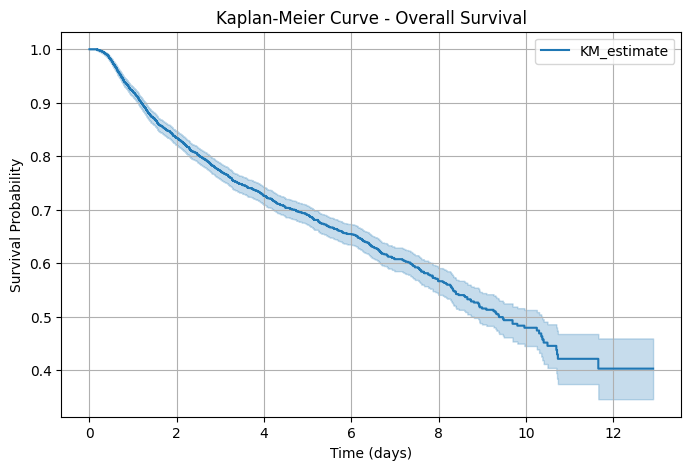

In [11]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

df['event'] = df['Status'].map({'Dead': 1, 'Alive': 0})

durations = df['Length FU']
events = df['event']

# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(durations, event_observed=events)

# Graphs
plt.figure(figsize=(8,5))
kmf.plot(ci_show=True)
plt.title('Kaplan-Meier Curve - Overall Survival')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()




['FEMALE' 'MALE']
['FEMALE' 'MALE']


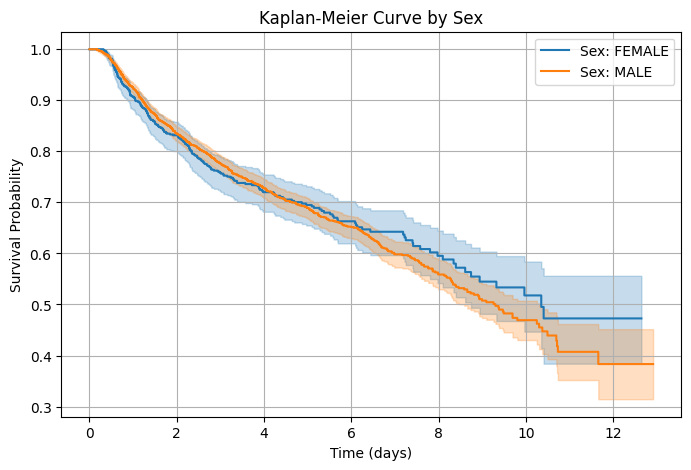

In [ ]:

print(df['Sex'].unique())

# Clean up Sex column
df['Sex'] = df['Sex'].astype(str).str.strip().str.upper()

# Confirm the result
print(df['Sex'].unique())

# Numeric
df['Length FU'] = pd.to_numeric(df['Length FU'], errors='coerce')
df['event'] = pd.to_numeric(df['event'], errors='coerce')

# Missing values
df = df.dropna(subset=['Sex', 'Length FU', 'event'])

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize model
kmf = KaplanMeierFitter()

# Create the plot
plt.figure(figsize=(8, 5))

# Fit and plot each group
for group in ['FEMALE', 'MALE']:
    mask = df['Sex'] == group
    kmf.fit(df.loc[mask, 'Length FU'], event_observed=df.loc[mask, 'event'], label=f'Sex: {group}')
    kmf.plot(ci_show=True)

# Add titles
plt.title('Kaplan-Meier Curve by Sex')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [18]:
from lifelines.statistics import logrank_test

# Separate groups
female = df[df['Sex'] == 'FEMALE']
male = df[df['Sex'] == 'MALE']

# Perform the test
results = logrank_test(
    female['Length FU'], male['Length FU'],
    event_observed_A=female['event'],
    event_observed_B=male['event']
)

# Show result
print("p-value:", results.p_value)


p-value: 0.672910228636513


Stage value counts:
Stage
0.0    44
Name: count, dtype: int64
Stage was dropped due to low variance.


AttributeError: The '.style' accessor requires jinja2

<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'Length FU'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7849.79
         time fit was run = 2025-08-05 00:03:48 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Sex       -0.03      0.98      0.08           -0.18            0.13                0.84                1.13
Age        0.04      1.04      0.00            0.04            0.05                1.04                1.05

           cmp to     z      p  -log2(p)
covariate                               
Sex          0.00 -0.33   0.74      0.43
Age          0.00 15.39 <0.005    175.11
---
Concordance = 0.62
Partial AIC = 15703.59
log-likelihood ratio test = 242.79 on 2 df
-log2(p) of ll-ratio test = 175.13

<Axes: xlabel='log(HR) (95% CI)'>

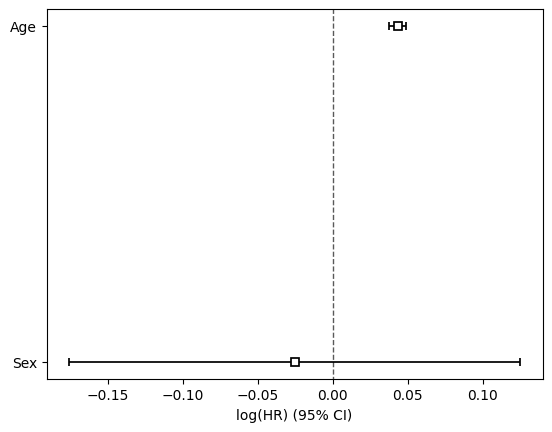

In [22]:
from lifelines import CoxPHFitter

# Select relevant columns for the Cox model
df_cox = df[['Length FU', 'event', 'Sex', 'Age', 'Stage']].copy()

# Convert 'Sex' from string to binary: FEMALE = 1, MALE = 0
df_cox['Sex'] = df_cox['Sex'].map({'FEMALE': 1, 'MALE': 0})

# Extract numeric value from Stage using regex
df_cox['Stage'] = df_cox['Stage'].astype(str).str.extract(r'(\d+)')
df_cox['Stage'] = pd.to_numeric(df_cox['Stage'], errors='coerce')

# Check how many unique values Stage has
print("Stage value counts:")
print(df_cox['Stage'].value_counts())

# Drop Stage if it has too few unique values
if df_cox['Stage'].nunique() < 3:
    df_cox = df_cox.drop(columns=['Stage'])
    print("Stage was dropped due to low variance.")

# Drop any missing values
df_cox = df_cox.dropna()

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='Length FU', event_col='event')

# Print model summary
cph.print_summary()

# Plot hazard ratios
cph.plot()
